# Week 11, Lab \#9

*March 27, 2024*

This Lab uses data from [the ERA5 climate reanalysis dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview) and soil organic carbon content from the International Geosphere-Biosphere Programme (IGBP).

## Introduction

**In today's lab, you'll train a statistical-learning model to predict Soil Organic Carbon (SOC) content across a global network of field sites.**

SOC is the main component of Soil Organic Matter (SOM) and consists of all organic carbon compounds in the soil: mostly decaying leaf litter and live or decomposing soil organisms like nematodes, fungi, and microbes. 

- SOC content, measured as grams of carbon per meter squared (g C m$^{-2}$) is generally higher in warmer and wetter climates, because these climates have more varied and productive plant life that contributes carbon inputs to the soil.
- BUT warmer and wetter conditions can also promote the *loss* of SOC content because they promote soil decomposition.

The ultimate fate of SOC is determined by a balance of the rate of carbon inputs to soil and the rate of soil decomposition. A good estimate of the rate of carbon inputs is given by **Net Primary Production (NPP).**

**The model we'll work with today is called Random Forest. We will:**

1. Project the NPP data to match the climate data
1. Index the gridded predictor datasets at FLUXNET sites
1. Train a Random Forest model to predict SOC
1. Run the Random Forest model to predict SOC across continuous grid
1. Optional: Project the climate data to the finer scale of the NPP data, then predict global SOC distribution

## The Validation or Test Dataset

Our random forest model is a **supervised learning model;** that is, it will learn how to predict SOC content based on examples of known SOC content that we provide.

Data on known SOC content come from the International Geosphere-Biosphere Programme (IGBP). I've pre-processed these data and stored the results in an HDF5 file.

In [1]:
import h5py

hdf = h5py.File('data/IGBP_SOC_data.h5', 'r')
hdf.keys()

<KeysViewHDF5 ['IGBP_SOC', 'IGBP_SOC_filled', 'coordinates']>

The SOC content are in units of kilograms of carbon per meter squared (kg C m$^{-2}$); we have 356 total measurements.

In [2]:
soc = hdf['IGBP_SOC_filled'][:]
soc.shape

(356,)

And we have a longitude-latitude coordinates for each measurement.

In [3]:
coordinates = hdf['coordinates'][:]
longitude = coordinates[:,0]
latitude = coordinates[:,1]
latitude.shape

(356,)

In [4]:
hdf.close()

We can make a "map" (illustration, really) of all of our SOC sites using `shapely`. This is just for illustrative purposes: you do NOT need to use `shapely` anywhere in this Lab.

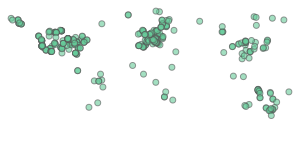

In [5]:
from shapely.geometry import MultiPoint
import numpy as np

coords = np.stack([longitude, latitude], axis = 1)
MultiPoint(coords)

If you're running a version of `shapely` that shows you a nice picture preview of your vector data (above), then you will see a number of points scattered across what looks vaguely like our planet's continents. A lot of the points are clustered in North America, Europe, and Australia.

## Preparing the Training Data

Let's read-in our training data.

In [6]:
import rasterio as rio

dataset_precip = rio.open('data/ERA5_1960-2000_mean_annual_total_precip_meters.tiff', mode = 'r')

# Convert from millimeters to meters
precip = dataset_precip.read(1) * 1000

dataset_temp = rio.open('data/ERA5_1960-2000_mean_annual_temperature_degK.tiff', mode = 'r')

# Convert from deg Kelvin to deg Centigrade
temp = dataset_temp.read(1) - 273.15

dataset_npp = rio.open('data/MODIS_MOD17_NPP_5km_2000.tif', mode = 'r')
npp = dataset_npp.read(1)

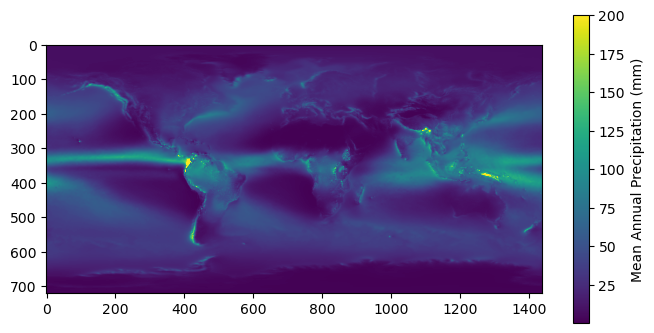

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 4))
plt.imshow(precip, vmax = 200)
cbar = plt.colorbar()
cbar.set_label('Mean Annual Precipitation (mm)')

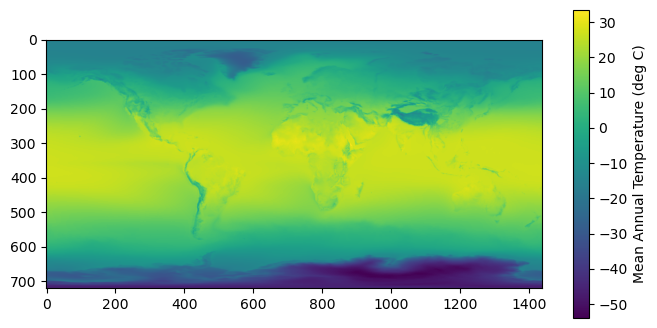

In [8]:
plt.figure(figsize = (8, 4))
plt.imshow(temp)
cbar = plt.colorbar()
cbar.set_label('Mean Annual Temperature (deg C)')

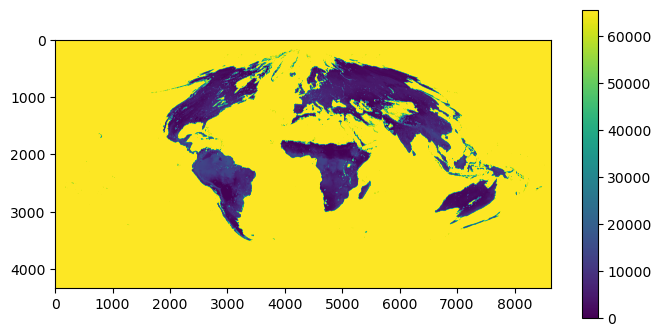

In [9]:
plt.figure(figsize = (8, 4))
plt.imshow(npp)
cbar = plt.colorbar()

**It looks like there are a couple of problems with the MODIS NPP data!** First, it's clearly in a different projection than the ERA5 climate data. Second, there are some NoData values we'll need to mask out. Third, we'll probably need to re-scale the NPP values; the data are stored as integer type:

In [10]:
npp.dtype

dtype('uint16')

This isn't a guarantee that the data need to be re-scaled, but we've been working with remote sensing data long enough now to know that it is a good indication that the current pixel values are not in the correct units.

---

## Problem 9.1: Clean and Project the MODIS NPP Data

[The MODIS MOD17A3H NPP data](https://lpdaac.usgs.gov/products/mod17a3hgfv061/) are supposed to be in units of kilograms of carbon per meter squared (kg C m$^{-2}$) but these values (~10,000) are way too high. We know we'll need to rescale the data, mask out NoData pixels, and project the data to match the climate predictor datasets. We'll actually want to mask out NoData pixels *before* rescaling so we don't inadvertently re-scale the NoData values.

**Write Python code that projects and scales the NPP data (`npp` NumPy array):**

1. Project the NPP data using bilinear resampling so that it matches our climate datasets;
1. Ensure that NoData pixels in the array are set to `np.nan`;
1. Re-scale the valid pixel values so they are in the correct geophysical units (kg C m$^{-2}$);

**Step 1 should be completed first so you can read the re-projected data as a NumPy array and use that for Steps 2-3.**

**Hint:** For **Step 2,** remember that `rasterio` knows what the NoData values are in each dataset; an easy way to ensure that NoData pixels get set to `np.nan` is to [set the `dst_nodata` argument.](https://rasterio.readthedocs.io/en/stable/api/rasterio.warp.html#rasterio.warp.reproject)

**Hint:** [Read the MOD17A3H User Guide](http://files.ntsg.umt.edu/data/GIS_Programming/docs/MOD17_User_Guide_V61.pdf), Table 4.2 (Page 24), for guidance on how to mask and rescale the values.

In [11]:
import rasterio as rio

# Create a temporary file
result = rio.open('temp.file', 'w+', driver = 'MEM', # The name doesn't matter, so we use 'temp.file'
                  width = dataset_precip.shape[1], # Mode is 'w+' so we can write first and then read
                  height = dataset_precip.shape[0], 
                  count = dataset_precip.count, 
                  dtype = np.float32, 
                  crs = dataset_precip.crs,
                  transform = dataset_precip.transform)

In [12]:
from rasterio.warp import reproject, Resampling

# Project NPP data using bilinear resampling to match climate datasets
reproject(
    source = rio.band(dataset_npp, 1), # Get the first band from `dataset_npp`
    destination = rio.band(result, 1), # Write it to the first band of the result we just created
    resampling = Resampling.bilinear,
    dst_nodata = np.nan                # Ensure nodata == np.nan
)

(Band(ds=<open DatasetWriter name='temp.file' mode='w+'>, bidx=1, dtype='float32', shape=(721, 1440)),
 None)

In [13]:
# Save first band of `result` as an array
npp = result.read(1)

# Rescale pixels to match kg C m^-2
npp = npp * 0.0001

---

## Cleaning Our Input Raster Data

**One issue with the NPP data that we may see from the plot above is that are lots of NoData pixels.** Some of our SOC sample sites are near coastlines, too, which may fall into NoData pixels.

Let's use a moving-window filter to smooth out and fill-in our NPP data. We want to fill-in NoData areas *adjacent* to valid data areas with the focal mean.

**Below, I'm assuming that `npp_wgs84` is the variable name of your re-projected NPP data, as a NumPy array.**

In [14]:
from scipy.ndimage import generic_filter

def nearby(window):
    # If all the pixels are NaN (i.e., open water), return NaN
    if np.isnan(window).all():
        return np.nan
    
    # If NONE of the pixels are NaN, return NaN (for now) -- See next step
    if not np.isnan(window).any():
        return np.nan
    
    # If just SOME of the pixels are NaN, return mean of all non-NaN pixels
    return np.nanmean(window)
        
npp_fill = generic_filter(npp, nearby, size = 3)

Because we don't want to change our original data anymore than we have to, we opted to put NaN in the land-locked areas where there are no missing data...

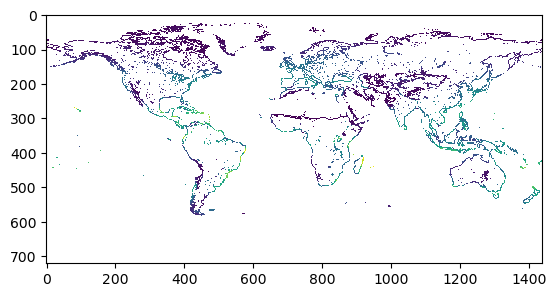

In [15]:
plt.imshow(npp_fill, interpolation = 'nearest')

These areas can be filled with the original data using `np.where()`: Wherever the filled dataset (pictured above) is NaN, use the original data.

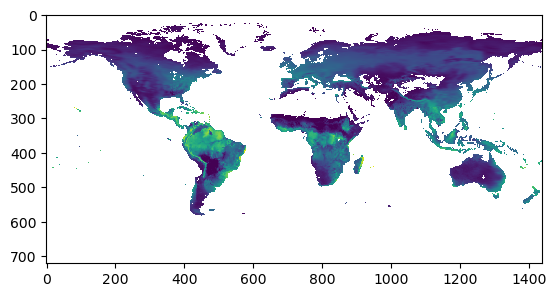

In [16]:
# Use the original data (not smoothed data) for the land-locked interiors
npp_wgs84_filled = np.where(np.isnan(npp_fill), npp, npp_fill)

plt.imshow(npp_wgs84_filled, interpolation = 'nearest', vmax = 2)

This is essentially like a nearest-neighbor interpolation, but where we used the *mean* of the nearest *group* of pixels instead of the nearest single pixel's value.

---

## Problem 9.2: Creating a Training Dataset

Next, we want to create training data for our SOC samples. We have global, gridded data on mean annual temperature (MAT), mean annual precipitation (MAP), and NPP but we need to get these values at each our SOC sample sites.

**Create a (356 x 3) NumPy array (356 rows, 3 columns) that contains the temperature, precipitation, and NPP data (in three separate columns) for each of the 356 sample sites.** It can be helpful to think of this problem as involving two steps:

1. Figure out the row-column coordinates, within the climate/NPP arrays, of each of our SOC sites.
2. Extracting the MAT, MAP, and NPP values at each row-column coordinate pair.

**Hint:** Use the arrays `temp`, `precip`, and `npp_wgs84_filled` for the MAT, MAP, and NPP data.

**Hint:** Recall that we can use `np.stack()` to join NumPy arrays together along a given axis; e.g., stacking two or more 1D arrays side-by-side would look like this:

In [17]:
A = np.arange(0, 5)
B = np.arange(5, 10)
np.stack([A, B], axis = 1)

array([[0, 5],
       [1, 6],
       [2, 7],
       [3, 8],
       [4, 9]])

**Hint:** Recall that we have arrays `latitude` and `longitude` that give the coordinates of each SOC sample site. We can use the affine transformation to convert between spatial coordinates and image coordinates.

In [18]:
dataset_precip.transform

Affine(0.25, 0.0, -180.0,
       0.0, -0.25, 90.0)

For example, what are the row-column coordinates of Missoula, MT within these global images?

In [19]:
# Order should be (longitude, latitude) or (x-coordinate, y-coordinate)
MISSOULA = (-114.011667, 46.8625)

# Returns the image coordinates at these spatial coordinates, in COLUMN, ROW order, unfortunately
~dataset_precip.transform * MISSOULA

(263.953332, 172.55)

In [20]:
image_coords = []

for coord in coordinates:
    image_coord = ~dataset_precip.transform * coord
    image_coords.append(image_coord)

image_coords = [(y, x) for x, y in image_coords]
image_coords[0:5]

[(493.8592071533203, 454.1607971191406),
 (472.95800018310547, 495.24560546875),
 (171.5333251953125, 765.2700004577637),
 (449.1320037841797, 1252.9959716796875),
 (412.3075981140137, 1244.47119140625)]

These values would need to be converted to integers to represent (column, row) locations.

I can double-check this is correct by copying some data, putting a "bright" (high value) pixel into the place I think Missoula is located, then plotting the data. The little yellow dot, below, tells me I've got Missoula in the right location.

In [21]:
image_coords = [(np.int16(x), np.int16(y)) for x, y in image_coords]
image_coords[0:5]

[(493, 454), (472, 495), (171, 765), (449, 1252), (412, 1244)]

In [22]:
# Note: image_coords, npp_wgs84_filled, temp, precip
# Use image coords to extract the values for each dataset at the coordinate
temps = np.array([temp[x, y] for x, y in image_coords])
precips = np.array([precip[x, y] for x, y in image_coords])
npps = np.array([npp_wgs84_filled[x, y] for x, y in image_coords])

print(temps[0:5])
print(precips[0:5])
print(npps[0:5])
print(temps.shape)
print(precips.shape)
print(npps.shape)

[17.628448  20.75351    1.7038574 22.47284   27.079468 ]
[25.278027 59.435303 57.404766 11.874972 48.423374]
[0.41225272 0.37868002 0.47169414 0.2238388  0.41345078]
(356,)
(356,)
(356,)


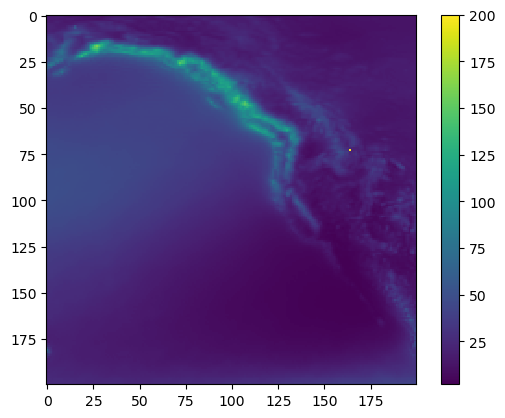

In [23]:
precip2 = precip.copy()
precip2[173, 264] = 2000 # Absurdly high precipitation value (especially for Missoula)

plt.imshow(precip2[100:300,100:300], interpolation = 'nearest', vmax = 200)
plt.colorbar()

If `training_data` is your (356, 3) NumPy array, then here is **a plot to check that temperature and precipitation values make sense:**

In [24]:
training_data = np.column_stack((temps, precips, npps))
training_data.shape

(356, 3)

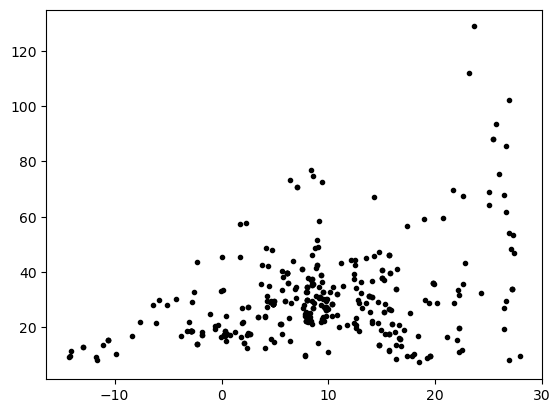

In [25]:
# This is assuming sample_temp is (356,) values sample_precip is (356,) values
sample_temp = training_data[:,0]
sample_precip = training_data[:,1]
plt.plot(sample_temp, sample_precip, 'k.')

---

## Any Missing Data?

For Random Forest to work, we cannot have any missing data.

In [26]:
np.argwhere(np.isnan(training_data))

array([[190,   2]], dtype=int64)

It looks like just one of the NPP values is missing. We'll fill it in with the mean NPP value. Regression-based predictors have a tendency to "regress towards the mean," i.e., predictions tend to be close to the mean value, so by filling in the mean value we're essentially lowering the importance of the NPP data in this sample but making sure the sample can still be used in our model.

In [27]:
training_data[190,2] = np.nanmean(npp_wgs84_filled)

Now we have no missing data!

In [28]:
np.argwhere(np.isnan(training_data))

array([], shape=(0, 2), dtype=int64)

---

## Problem 9.3: Split Training-Testing Data

Recall that in order to accurately estimate the performance of our model, we want to reserve some of our data so that we **train** and **test** (validate) the model on separate samples.

**Randomly split the training data (356 sites) into separate training and testing datasets.** The test data should be 20% of our samples (71 sites), so the remaining 80% (285 sites) can be used for training. 

**You should define the following Python variables:**

- `soc_train`, a 1D, 285-element list or NumPy array of the SOC data to be used in training
- `data_train`, a (285 x 3) NumPy array of the predictor data to be used in training
- `soc_test`, a 1D, 71-element list or NumPy array of the SOC data to be used in testing
- `data_test`, a (71 x 3) NumPy array of the predictor data to be used in model testing

**NOTE:** If you use `np.random.randint()` you may get duplicate numbers, as in this example (9 is included twice). So you might not want to use this function...

In [37]:
np.random.seed(42)

# Generate 71 random integers from 0 to 356
idx = np.random.choice(357, size = 71, replace = False)
mask = np.in1d(np.arange(0, soc.shape[0]), idx[0:71])
# print(mask.shape)
# print(sum(mask))

# soc train-test split
soc_test = soc[mask]
soc_train = soc[~mask]

# training_data train-test split
data_test = training_data[mask]
data_train = training_data[~mask]

print(f'soc train: {soc_train.shape}')
print(f'soc test: {soc_test.shape}')
print(f'data train: {data_train.shape}')
print(f'data test: {data_test.shape}')

soc train: (285,)
soc test: (71,)
data train: (285, 3)
data test: (71, 3)


Instead, consider: If the IGBP SOC data points ($N$ total) were randomly ordered, you could take the first $M$ values to obtain $M$ testing values and the remaining $N-M$ values could be used for training.

---

## Random Forest Regression

As we've seen, scikit-learn provides easy interfaces for a number of fairly sophisticated classification and regression algorithms. [Random forest regression](https://scikit-learn.org/stable/modules/ensemble.html#forest) is a technique for predicting continuous values from training data based on a large collection ("ensemble") of **decision trees.** Each decision tree is trained on only a part of the training data and each tree gets to vote on the final, predicted value after all trees are fit.

**What's a decision tree?** Consider the example below. We start at the top of the tree and ask a series of Yes/No questions about our data. In this example of animal traits, we first ask if the animal is warm-blooded. If the answer is "No," then we arrive at a *terminal* node of the decision tree: our final decision, i.e., the animal is not warm-blooded. If the answer is "Yes," however, we have more branching nodes (more questions to ask).

![](./assets/decision_tree.png)

For regression problems, these branches might be something like "Is the mean annual temperature greater than 25 deg C?" This question might turn out to be a good way of determining whether SOC content is high or low, for instance. **By combining multiple Yes/No tests together, in a series, we can construct complex segmentations of our data, assigning a certain mean SOC content to a few samples that end up at the same terminal node.**

### Random Forest Regression with scikit-learn

We're now ready to fit out Random Forest model! [You should read about the `RandomForestRegressor` class; there are some parameters we might tweak in order to improve our results.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

For this first attempt, we'll accept all the default parameters (e.g., 100 random trees) but we'll insist that the terminal nodes ("leafs") must have at least 2 samples in them; i.e., the trees can't become so specialized that only a single SOC sample would match.

In [38]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(min_samples_leaf = 2)

As with other scikit-learn models, after we've initialized the model we need to `fit()` the model.

In [39]:
model.fit(data_train, soc_train)

RandomForestRegressor(min_samples_leaf=2)

The last step with our model is to make predictions! We can calculate the goodness-of-fit compared to our training data, the **Training RMSE;** this isn't an objective measure of our model's performance because it is based on the data we used to train the model, but it will give us a good idea of where we are so far.

In [40]:
from sklearn.metrics import mean_squared_error

predictions = model.predict(data_train)
mean_squared_error(soc_train, predictions, squared = False) # We want RMSE, not MSE, so squared = False

C:\Users\by197116\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3.774522634512227

My model reports a root-mean squared error (RMSE) of 3.9 kg C m$^{-2}$ of SOC content. That's not too bad, considering it is about 6% of the range (maximum minus minimum) of SOC values.

In [41]:
100 * (3.77 / soc.max())

5.610419313301846

**A better measure of our model's performance comes from calculating the RMSE based on data the model hasn't seen yet: our test data.**

In [42]:
predictions = model.predict(data_test)
mean_squared_error(soc_test, predictions, squared = False)

C:\Users\by197116\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


8.45914751401154

In [43]:
100 * (8.45 / soc.max())

12.57507777119379

A normalized **Test RMSE** of ~10% is pretty common for regression-based models.

We can also make a 1:1 scatterplot of predicted versus observed SOC content.

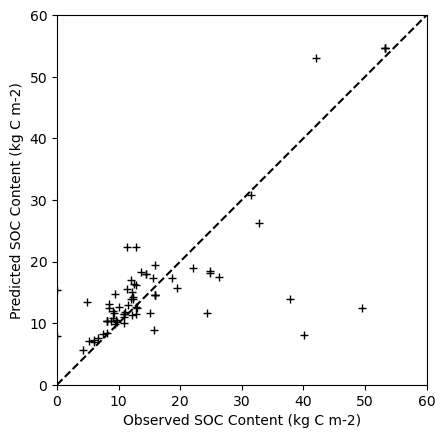

In [44]:
import matplotlib.lines as mlines

fig, ax = plt.subplots()
ax.plot(soc_test, predictions, 'k+')
ax.set_aspect(1)
plt.ylim(0, 60)
plt.xlim(0, 60)
plt.xlabel('Observed SOC Content (kg C m-2)')
plt.ylabel('Predicted SOC Content (kg C m-2)')

# Some additional plotting magic to make a diagonal line
transform = ax.transAxes
line = mlines.Line2D([0, 1], [0, 1], color = 'black', linestyle = 'dashed')
line.set_transform(transform)
ax.add_line(line)
plt.show()

**Would changing the `min_samples_leaf` parameter improve the results?** We can calculate the Training RMSE that we would obtain for different values of `min_samples_leaf`.

In [45]:
error = []

for i in range(2, 10):
    model = RandomForestRegressor(min_samples_leaf = i)
    model.fit(data_train, soc_train)
    predictions = model.predict(data_train)
    rmse = mean_squared_error(soc_train, predictions, squared = False)
    error.append(rmse)
    
error

C:\Users\by197116\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\by197116\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\by197116\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\by197116\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in versio

[3.8287577217403332,
 4.29161609915431,
 4.605853368891743,
 4.837746705784262,
 5.120709441100707,
 5.28821530414111,
 5.579478372675684,
 5.963014980677888]

### Inference with Random Forest

So far, in class and in Lab, we've been focused on making good *predictions* with our models. But remember that another goals of statistical learning is statistical *inference,* i.e., learning the *nature* of the relationship(s) between predictor variables (e.g., MAT, MAP, and NPP) and an outcome variable (SOC).

Random Forest is a good model for inference because it consists of multiple decision trees that each use different parts of the data, including different variables. This allows for the calculation of **importance metrics,** which tells us which predictive features are most important for predicting the outcome.

Below, we can see that, in order of the predictors: MAT is the most important predictor (0.4699 in my notebook), MAP the second-most (0.3791), and NPP last (0.1510). These sum to one and can be intereprested as the proportion of the variance in the prediction (SOC) that is reduced due to that predictor variable.

In [46]:
model.feature_importances_

array([0.62407717, 0.27338414, 0.10253868])

[Read more about the `feature_importances_` property.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)

---

## Problem 9.4: Mapping Predicted SOC Content

Now for something really exciting! We have a model that can predict SOC content with reasonable accuracy. **Could we map predicted SOC content for the entire global land domain?**

**Using a trained `RandomForestRegressor` model (as above), predict SOC content for the entire globe, using the gridded MAT, MAP, and NPP data we loaded earlier.**

You should start with this `model`, below, just in case you have a predefined `model`, from above, that isn't what we want.

In [47]:
model = RandomForestRegressor(min_samples_leaf = 2)
model.fit(data_train, soc_train)

RandomForestRegressor(min_samples_leaf=2)

**Hint:** Remember that scikit-learn models expect to get predictor data in a specific format: As a 2D array where the columns are the predictor variables and the rows are the samples. This is why we made a (356 x 3) NumPy array earlier: 356 samples (rows) and 3 predictor variables (columns). For this problem, you'll still have 3 predictor variables (columns) but you'll have many more rows: one for every pixel in our global map.

**Hint:** `RandomForestRegressor` refuses to make predictions if there are any NaNs (`np.nan`) in your data. **You'll get an error if there are any NaNs in your data!** To deal with this issue, you'll need to fill-in the NaNs in our NPP data with dummy values (like "NoData" values) and then replace them later. I've written this part for you, below! Note that the temperature and precipitation data come from global, gridded model datasets, so they aren't missing any data.

In [48]:
np.isnan(temp).any()

False

In [49]:
np.isnan(precip).any()

False

In [50]:
np.isnan(npp_wgs84_filled).any()

True

In [51]:
npp = np.where(np.isnan(npp_wgs84_filled), -9999, npp_wgs84_filled)
np.isnan(npp).any()

False

In [52]:
print(temp.shape)
print(precip.shape)
print(npp.shape)

(721, 1440)
(721, 1440)
(721, 1440)


In [55]:
temp1 = temp.reshape(-1)
precip1 = precip.reshape(-1)
npp1 = npp.reshape(-1)

glob_data = np.column_stack((temp1, precip1, npp1))
glob_data.shape

(1038240, 3)

In [56]:
glob_preds = model.predict(glob_data)

---

## Optional Challenges

1. There are many other optional keyword arguments to `RandomForestRegressor` that will change model behavior! Try them out! Can you get a better result (in terms of Test RMSE)?
2. We have a pretty small dataset (356 samples). In such cases, it's often better to use **k-fold Cross-Validation** when fitting and evaluating models. [Read more about that here](https://scikit-learn.org/stable/modules/cross_validation.html) and see if you can use it to simultaneously fit and validate your Random Forest model.